In [11]:
import pandas as pd
import numpy as np

main_data=pd.read_csv("../10_Data/QQQ_MarketRisk.csv")
main_data.head()

,Date,QQQ_Return,QQQ_Realized_Volatility,QQQ_Volume,VIX,RSI_14,VXN,FedRate
0,2015-02-24,0.000737,0.141940,19745000,13.69,86.433699,14.26,0.018
1,2015-02-25,-0.002486,0.142386,19472300,13.84,84.469704,14.38,0.015
2,2015-02-26,0.005077,0.100264,22255500,13.91,83.772983,14.33,0.013
3,2015-02-27,-0.004408,0.099524,27757600,13.34,85.464910,14.62,0.008
4,2015-03-02,0.009041,0.099096,22988600,13.04,90.718296,14.27,0.005


1. Test for stationarity: ADF test 

In [12]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(main_data["QQQ_Return"]) 
print('p-value:', result[1])

p-value: 3.790511348552969e-29


2. Testing for ARCH Effects

In [13]:
from statsmodels.stats.diagnostic import het_arch
lag_order = 10 
arch_test = het_arch(main_data["QQQ_Return"], maxlag=lag_order)
print('p-value:', arch_test[1])  

p-value: 2.429725489347034e-144


/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_10772/3726756681.py:3: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(main_data["QQQ_Return"], maxlag=lag_order)


3. basic GARCH(1,1)

In [14]:
from arch import arch_model
model = arch_model(main_data["QQQ_Return"], vol='Garch', p=1, q=1)  # GARCH(1,1)
result = model.fit(update_freq=5, disp='on')

forecasts = result.forecast(horizon=1)
predicted_volatility = forecasts.variance.iloc[-1] ** 0.5

predicted_volatility


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001902. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


h.1    0.012821
Name: 2478, dtype: float64

### test

In [20]:
main_data["Date"] = pd.to_datetime(main_data["Date"])
main_data = main_data.sort_values("Date").reset_index(drop=True)

train_cutoff_date = pd.Timestamp("2020-01-01")
test_end_date = pd.Timestamp("2023-12-31")

train_set = main_data[main_data["Date"] < train_cutoff_date]
test_set = main_data[(main_data["Date"] >= train_cutoff_date) & (main_data["Date"] <= test_end_date)]

# Rolling forecast
predicted_vols = []

for i in range(len(test_set)):
    current_test_date = test_set.iloc[i]["Date"]

    sub_data = main_data[main_data["Date"] < current_test_date]["QQQ_Return"]

    model = arch_model(sub_data, vol='Garch', p=1, q=1)
    result = model.fit(disp='off')
    forecast = result.forecast(horizon=1)
    pred_var = forecast.variance['h.1'].iloc[-1]
    predicted_vols.append(np.sqrt(pred_var))


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001174. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/CynthiaSY/miniforge3/lib/python3.12/site-

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


predicted_vol_series = pd.Series(predicted_vols, index=test_set.index)

predicted_vol_series_ann = predicted_vol_series * np.sqrt(252)

y_true = test_set["QQQ_Realized_Volatility"]     
y_pred = predicted_vol_series_ann               

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# R-squared (Coefficient of Determination)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.4f}")



Mean Squared Error (MSE): 0.002683
Root Mean Squared Error (RMSE): 0.051795
Mean Absolute Error (MAE): 0.032008
R-squared (R²): 0.8350


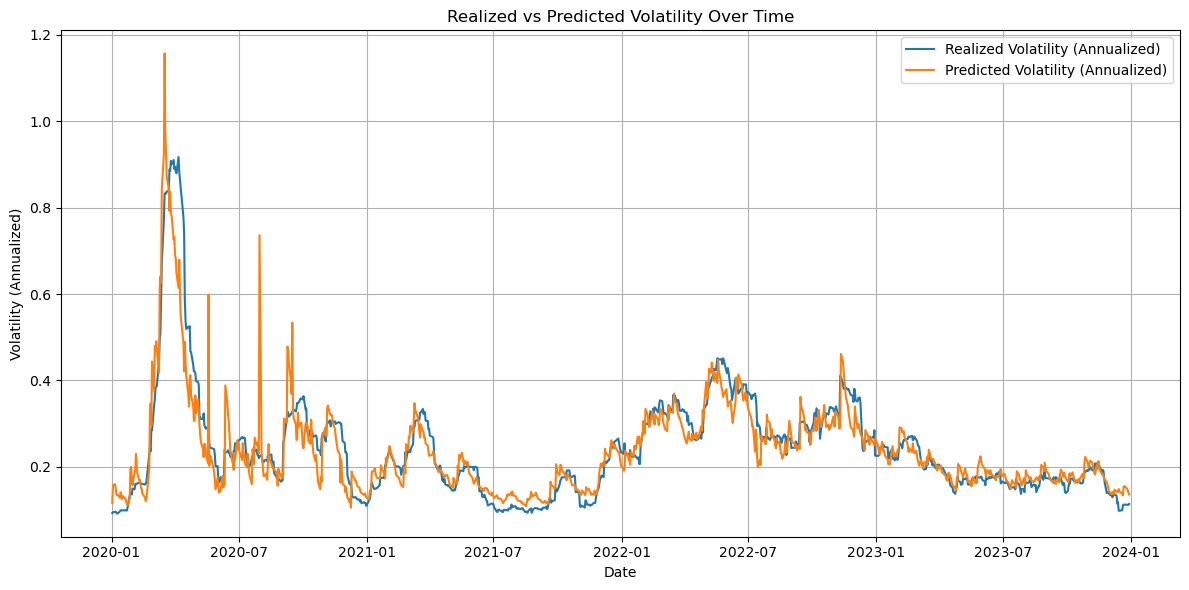

In [25]:
import matplotlib.pyplot as plt

y_true.index = test_set["Date"].values
y_pred.index = test_set["Date"].values


plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true, label="Realized Volatility (Annualized)")
plt.plot(y_pred.index, y_pred, label="Predicted Volatility (Annualized)")
plt.legend()
plt.title("Realized vs Predicted Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility (Annualized)")
plt.grid(True)
plt.tight_layout()
plt.show()
